In [1]:
import requests, time
from urllib.error import URLError, HTTPError
import fastai
from fastai.vision.all import *

In [2]:
## Where is data?
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
## How is the data directory structured?
path.ls()

(#3) [Path('/Users/marcos/.fastai/data/mnist_sample/valid'),Path('/Users/marcos/.fastai/data/mnist_sample/labels.csv'),Path('/Users/marcos/.fastai/data/mnist_sample/train')]

In [4]:
## How is the training directory structured?
(path/'train').ls()

(#2) [Path('/Users/marcos/.fastai/data/mnist_sample/train/7'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3')]

In [5]:
## Grabbing the data we want to start with
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [6]:
## What does this look like...
threes

(#6131) [Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10000.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10011.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10031.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10034.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10042.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10052.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/1007.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10074.png'),Path('/Users/marcos/.fastai/data/mnist_sample/train/3/10091.png')...]

In [7]:
## Lets look at an example...
im3_path = threes[4]
im3 = Image.open(im3_path)
im3

In [8]:
## What does this look like as a tensor?
im3_t = tensor(im3)
im3_t

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   5,  60, 136, 136, 147, 254, 255,
         199, 111,  18,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  25, 152, 253, 253, 253, 253, 253, 253,
         253, 253, 253, 124,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 135, 22

In [9]:
## Lets see how this looks in a dataframe
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,5,60,136,136,147,254,255,199,111,18,9,0,0,0,0
1,0,0,25,152,253,253,253,253,253,253,253,253,253,124,0,0,0,0
2,0,0,135,225,244,253,202,200,181,164,216,253,253,211,151,0,0,0
3,0,0,0,30,149,78,3,0,0,0,20,134,253,253,224,0,0,0
4,0,0,0,0,0,0,0,0,0,0,28,206,253,253,224,0,0,0
5,0,0,0,0,0,0,0,0,0,0,78,253,253,253,224,0,0,0
6,0,0,0,0,0,0,0,0,0,5,99,234,253,253,224,0,0,0
7,0,0,0,0,0,0,0,14,142,220,219,236,253,253,240,121,7,0
8,0,0,0,0,0,0,0,24,253,253,253,253,235,233,253,253,185,53
9,0,0,0,0,0,0,0,8,150,194,194,194,53,40,97,253,253,170


In [10]:
## Lets see how this looks in a dataframe
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,5,60,136,136,147,254,255,199,111,18,9,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,25,152,253,253,253,253,253,253,253,253,253,124,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,135,225,244,253,202,200,181,164,216,253,253,211,151,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,30,149,78,3,0,0,0,20,134,253,253,224,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,206,253,253,224,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,78,253,253,253,224,0,0,0,0,0,0,0,0,0


# Making a baseline to compare against
Here, we could just take the average pixel value of all of the threes and all of the sevens and just classify digents based on which average their pixel aveage is closer to.

In [11]:
## Load all of the images in as tensors
seven_tensors = [tensor(Image.open(o)) for o in sevens] 
three_tensors = [tensor(Image.open(o)) for o in threes] 
len(three_tensors),len(seven_tensors)

(6131, 6265)

<Axes: >

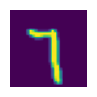

In [12]:
## We can use fastai's builtin show_image function to look at the individual digits
show_image(seven_tensors[222])

In [13]:
seven_tensors[222].shape

torch.Size([28, 28])

In [14]:
## Stack the tensors, and normalize to values between 0 and 1
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

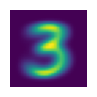

In [15]:
## What does the 'average' digit look like?
mean3 = stacked_threes.mean(0)
show_image(mean3);

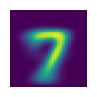

In [16]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

## Looking at the distance from the mean digit to an arbitrary digit
Here our "mean" digits are our "ideal" and we want to see how far away any arbitrary digit is from this ideal.

In [17]:
## Grabbing arbitrary digits
a_3 = stacked_threes[21]
a_7 = stacked_sevens[33]

<Axes: >

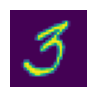

In [18]:
show_image(a_3)

<Axes: >

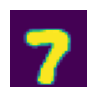

In [19]:
show_image(a_7)

In [20]:
## Computing the L1 and L2 distances

## From the arbitrary three to the ideal three
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1199), tensor(0.2196))

In [21]:
## From the arbitrary three to the ideal seven
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1338), tensor(0.2605))

So... it looks like the arbitrary three is indeead closer to the ideal three than the it is to the ideal seven (in either norm). This is probably a reasonable baseline to start with.

Lets try it out on our validation set.

In [22]:
mean3.shape

torch.Size([28, 28])

In [23]:
## Grab and normaize the validation data
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]) 
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [24]:
## Defining our metrics
def mnist_baseline_l1(a,b):
    ## (a-b) compute the elementwise difference between a and b.
    ## a will be a tensor of shape [num_samples, 28, 28]
    ## b will be a tensor of shape [28, 28]
    ## PyTorch will use _broacasting_ to subtract b from each of the samples
    ## mean(-1,-2) tells PyTorch we want the mean over the last two indices of the tensor
    ## These represent the 28x28 pixels in each image (the first index is just the sample's position in the stack)
    return (a-b).abs().mean((-1,-2))

def mnist_baseline_l2(a,b):
    return ((a-b)**2).mean((-1,-2)).sqrt()

## Evaluating our baselines on the validation data

In [25]:
## Computing the distance from our validation set to our ideal
valid_3_to_ideal_3_l1 = mnist_baseline_l1(valid_3_tens, mean3)
valid_3_to_ideal_3_l1, valid_3_to_ideal_3_l1.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

In [26]:
valid_3_to_ideal_3_l2 = mnist_baseline_l2(valid_3_tens, mean3)
valid_3_to_ideal_3_l2, valid_3_to_ideal_3_l2.shape

(tensor([0.2913, 0.2089, 0.2475,  ..., 0.1997, 0.2031, 0.2955]),
 torch.Size([1010]))

In [27]:
def is_3_l1(x): return mnist_baseline_l1(x, mean3)< mnist_baseline_l1(x,mean7)
def is_3_l2(x): return mnist_baseline_l2(x, mean3)< mnist_baseline_l2(x,mean7)

In [28]:
accuracy_3s_l1 = is_3_l1(valid_3_tens).float().mean()
accuracy_7s_l1 = (1 - is_3_l1(valid_7_tens).float()).mean()
accuracy_3s_l1,accuracy_7s_l1,(accuracy_3s_l1+accuracy_7s_l1)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [29]:
accuracy_3s_l2 = is_3_l2(valid_3_tens).float().mean()
accuracy_7s_l2 = (1 - is_3_l2(valid_7_tens).float()).mean()
accuracy_3s_l2,accuracy_7s_l2,(accuracy_3s_l2+accuracy_7s_l2)/2

(tensor(0.9584), tensor(0.9737), tensor(0.9661))